In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

import os
import pandas as pd
import skfmm

from thefuzz import fuzz, process

In [2]:
def geodesic_distance_transform(img, root):
    m = np.copy(img)
    m[root] = False
    m = np.ma.masked_array(m, ~img)
    return skfmm.distance(m, order=2).data

def read_binary_img(filename, threshold=100):
    bimg = cv2.imread(filename)[:,:,0]
    bimg[bimg < threshold] = 0
    bimg[bimg > 0] = 1
    bimg = bimg.astype(bool)

    return bimg

def get_largest_elements(comp, alpha=0.25):
    labels,num = ndimage.label(comp, structure=ndimage.generate_binary_structure(comp.ndim, 1))
    print(num,'components')
    hist, bins = np.histogram(labels, bins=num, range=(1,num+1))
    print(np.sort(hist)[::-1][:20])
    tot = np.sum(hist)

    box = np.zeros(comp.shape, dtype=bool)
    for i in np.nonzero(hist/tot > alpha)[0]:
        box = box | (labels == i+1)
    print('Returned only the largest',i+1,'components')
    return box

In [74]:
fs = 12
genotypes = ['CAL','MLB','222','299','517','521']
runnum = 1

src = '../run{:02d}/'.format(runnum)

psrc = src + 'processed/'
gsrc = src + 'gudhi/'
ddst = src + 'diagnostic/'
hdst = src + 'histograms/'

if not os.path.isdir(hdst):
    os.mkdir(hdst)

gidx = 5
bfiles = sorted(glob(psrc + '*{}*.npy'.format(genotypes[gidx])))
print('Total number of files:\t{}\n'.format(len(bfiles)))
for i in range(len(bfiles)):
    print(i, bfiles[i], sep='\t')

Total number of files:	8

0	../run01/processed/222F_side1_022817002_-_completed_binary_2066_3439_0_3976.npy
1	../run01/processed/222F_side1_030117010_-_completed_binary_845_4712_0_6296.npy
2	../run01/processed/222F_side2_022817003_-_completed_binary_2204_3773_0_4299.npy
3	../run01/processed/222F_side2_030117011_-_completed_binary_995_4710_0_6294.npy
4	../run01/processed/222M_side1_022817026_-_completed_binary_1436_4289_0_4602.npy
5	../run01/processed/222M_side1_030117006_-_completed_binary_1793_3646_0_2708.npy
6	../run01/processed/222M_side2_022817027_-_completed_binary_1329_3876_0_4497.npy
7	../run01/processed/222M_side2_030117007_-_completed_binary_1699_3557_0_2548.npy


In [81]:
idx = 5
bname = os.path.splitext(os.path.split(bfiles[idx])[1])[0].split('_-_')[0]
ceros = np.array(os.path.splitext(bfiles[idx])[0].split('_')[-4:], dtype=int)
zeroslice = np.s_[ceros[2]:ceros[3], ceros[0]:ceros[1]]

print(bfiles[idx], bname, sep='\n')
gimg = np.load(bfiles[idx], allow_pickle=True)

../run01/processed/222M_side1_030117006_-_completed_binary_1793_3646_0_2708.npy
222M_side1_030117006


In [82]:
graydots = glob('../Graydot_images_run{:02d}/*.jpg'.format(runnum))
graydots = [ os.path.split(graydots[i])[1].split('.jpg')[0] for i in range(len(graydots)) ]
fmatch = process.extractOne(bname, choices=graydots, scorer=fuzz.partial_ratio)
if fmatch[1] > 90:
    filename = glob('../Graydot_images_run{:02d}/{}*.jpg'.format(runnum, fmatch[0]))
    print(filename)
    bimg = cv2.imread(filename[0])[zeroslice][:,:,0]
    crownmask = (bimg > 100) & (bimg < 200)
    crown = ndimage.center_of_mass(crownmask)
    crown = tuple(np.array(crown).astype(int))
    print(crown)

['../Graydot_images_run01/222M_side1_030117006.jpg_Binary_roots (1).jpg']
(1667, 573)


In [83]:
stem = np.zeros_like(gimg)
stemcorrected = glob('../Graydot_images_run{:02d}/StemCorrected/*.jpg'.format(runnum))
if len(stemcorrected) > 1:
    stemcorrected = [ os.path.split(stemcorrected[i])[1].split('.jpg')[0] for i in range(len(stemcorrected)) ]
    smatch = process.extractOne(bname, choices=stemcorrected, scorer=fuzz.partial_ratio)
    if smatch[1] > 90:
        filename = glob('../Graydot_images_run{:02d}/StemCorrected/{}*.jpg'.format(runnum, smatch[0]))
        print(filename)
        simg = cv2.imread(filename[0])[zeroslice][:,:,0]
        stem = get_largest_elements( (simg > 20) & (simg < 50) , alpha = 0.1)

rmask = gimg.copy()
rmask[stem] = False

# Make a proper geodesic watershed

In [87]:
rootbase = ( 0 , int(ndimage.center_of_mass(gimg[0])[0]) )
cgdt = geodesic_distance_transform(gimg, crown)
bgdt = geodesic_distance_transform(gimg, rootbase)
rstem = bgdt < bgdt[crown]
rstem[~gimg] = False
b2c = np.sqrt(np.sum(np.power([crown[i] - rootbase[i] for i in range(len(crown))], 2)))
print(cgdt[rstem].max() - b2c)
cgdt[rstem] *= -1

38.68952516171953


In [88]:
len(cgdt[rstem])/np.sum(cgdt != 0)

0.32931319256162656

../run01/diagnostic/crown_geodesic_-_222M_side1_030117006


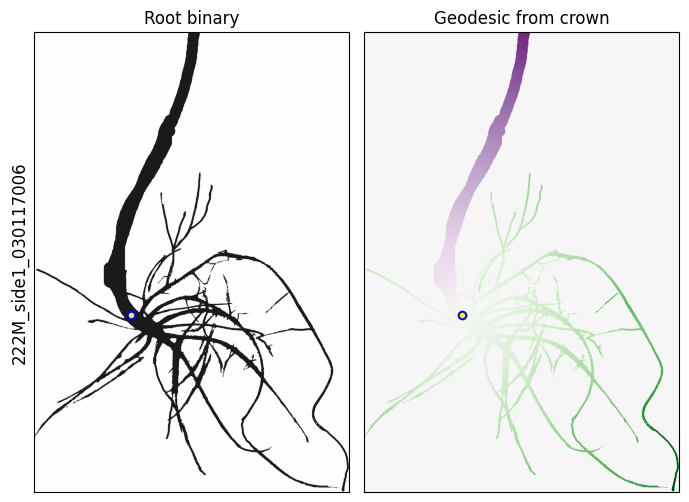

In [89]:
s = 30
ims = [gimg, cgdt]
title = ['Root binary', 'Geodesic from crown'] + ['' for _ in range(len(ims))]
cmap = ['RdGy', 'PRGn'] + ['inferno' for _ in range(len(ims)) ]

fig, ax = plt.subplots(1,len(ims), figsize=(3.5*len(ims),5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i,im in enumerate(ims):
    ax[i].imshow(im, cmap=cmap[i], origin='upper', vmin=-1*im.max())
    ax[i].tick_params(labelleft=False, left=False, bottom=False, labelbottom=False)
    ax[i].scatter(crown[1], crown[0], marker='o', color='yellow', edgecolor='blue', linewidth=1.5, s=s)
    ax[i].set_title(title[i], fontsize=fs);

i = 0
ax[i].set_ylabel(bname, fontsize=fs)
fig.tight_layout();

filename = ddst + 'crown_geodesic_-_' + bname
print(filename)
plt.savefig(filename +'.png', format='png', bbox_inches='tight', dpi=200)

# Compare healthy from diseased

In [16]:
imtype = ['Diseased', 'Healthy', 'Binary']
img = [ (read_binary_img(glob(src + '{}*/*{}*'.format(imtype[i], bname.replace('-','*')))[0], 25)[zeroslice])*rmask for i in range(2) ]
cgeod = [ cgdt*img[i] for i in range(len(img)) ]

In [17]:
print('Raw img')
for i in [0,1]:
    _, nums = ndimage.label(img[i], structure=ndimage.generate_binary_structure(2,1))
    print('[',i,']\t',imtype[i],'\tFound',nums,'connected components')

print('--\nCrown geodesic')
for i in [0,1]:
    _, nums = ndimage.label(cgeod[i], structure=ndimage.generate_binary_structure(2,1))
    print('[',i,']\t',imtype[i],'\tFound',nums,'connected components')

Raw img
[ 0 ]	 Diseased 	Found 3042 connected components
[ 1 ]	 Healthy 	Found 9767 connected components
--
Crown geodesic
[ 0 ]	 Diseased 	Found 3042 connected components
[ 1 ]	 Healthy 	Found 9767 connected components


In [18]:
gvals = cgdt[rmask]
vmin = int(np.floor(np.min(gvals)))
vmax = int(np.ceil(np.max(gvals)))
hist, bins = np.histogram(gvals, bins=range(vmin,vmax+1))
print(cgdt.size, cgdt[gimg].shape, cgdt[rmask].shape, sep='\t')

12101109	(876399,)	(876399,)


In [28]:
for i in range(len(cgeod)):
    hist, bins = np.histogram(cgeod[i][img[i]], bins=range(vmin,vmax+1))
    filename = hdst + bname + '_-_{}_{}_crown_geodesic.csv'.format(bins[-1], imtype[i].lower())
    print(filename)
    np.savetxt(filename, hist, delimiter=',', fmt='%d')

../run02/histograms/4-222-2-M-1-401_-_4236_diseased_crown_geodesic.csv
../run02/histograms/4-222-2-M-1-401_-_4236_healthy_crown_geodesic.csv
